In [ ]:
import os
import ee
import geemap
import geopandas as gp
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

from tqdm import tqdm

idir_d = 'C:/sarfaraz/Project_GW_attribution/2_GW_attribution_work/9_LU_kw/01_data/'
idir_o = 'C:/sarfaraz/Project_GW_attribution/2_GW_attribution_work/9_LU_kw/04_output/01_kw_LU/'

In [66]:
ee.Initialize()

In [67]:
cdl = ee.ImageCollection('USDA/NASS/CDL')
nlcd = ee.ImageCollection('USGS/NLCD')

In [68]:
Map = geemap.Map()

point = ee.Geometry.Point([-119.29,36.33])

image = (
    ee.ImageCollection('USDA/NASS/CDL')
    .filterBounds(point)
    .filterDate('2018-01-01', '2019-12-31')
    .first()
)

Map.centerObject(point, 8)
Map.addLayer(image, {}, "Crop Landcover")

Map

Map(center=[36.33, -119.29], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [69]:
def gdf_to_ee_poly(gdf, simplify = False):

    if simplify:
        gdf = gdf.geometry.simplify(0.01)

    lls = gdf.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)

    return area

<AxesSubplot:>

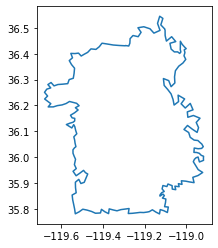

In [70]:
gdf = gp.read_file("../03_shape/Kaweah_subregion.shp")
gdf = gdf.to_crs('epsg:4326')
gdf.boundary.plot()

In [71]:
area_shp = gdf['geometry']
# area_gdf = gp.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[area_shp])
area = gdf_to_ee_poly(area_shp)

In [72]:
area.getInfo()

{'type': 'Polygon',
 'coordinates': [[[-119.1024549643879, 36.49468476131673],
   [-119.12273259897204, 36.511766227137386],
   [-119.11295251486484, 36.53694086015456],
   [-119.12812441478125, 36.54530125240756],
   [-119.13845664473051, 36.51763875166716],
   [-119.12671680179517, 36.49053688665926],
   [-119.15579879751971, 36.47990014334511],
   [-119.1747258877137, 36.496743378668675],
   [-119.20435804681112, 36.50457105660536],
   [-119.23249739273916, 36.50071398460893],
   [-119.2174771839869, 36.48306610328621],
   [-119.23138905674111, 36.46613525636091],
   [-119.25627722726635, 36.47061986104748],
   [-119.27016603657562, 36.45841775612063],
   [-119.27131219757202, 36.44066608909651],
   [-119.27662956833015, 36.43003735346529],
   [-119.29229867565977, 36.43183192158228],
   [-119.29375882040137, 36.43090472397491],
   [-119.32180250056781, 36.43203720786499],
   [-119.35092300140762, 36.43386863853556],
   [-119.37891018664357, 36.43764134238467],
   [-119.405015249563

In [209]:
# function to get unique values
def unique(list1):
  
    # initialize a null list
    unique_list = []
      
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    return(unique_list)

# count repeat of a selected value
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

def cdl_pr(yr):
    im = (
    ee.ImageCollection('USDA/NASS/CDL')
    # ee.ImageCollection('USDA/NASS/CDL/{}'.format(str(yr)))
    .filterBounds(area)
    .filterDate((str(yr) +'-01-01'), (str(yr + 1) +'-12-31'))
    .first()
    )

    results_dict  = im.reduceRegion(
        reducer = ee.Reducer.toList(),
        geometry = area,
        scale = 30,
        bestEffort= True)

    cdl_dict = results_dict.getInfo()
    
    return cdl_dict

def nlcd_pr(yr):
    im = (
    ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
    # ee.ImageCollection('USDA/NASS/CDL/{}'.format(str(yr)))
    .filterBounds(area)
    .filterDate((str(yr) +'-01-01'), (str(yr + 1) +'-12-31'))
    .first()
    )

    results_dict  = im.reduceRegion(
        reducer = ee.Reducer.toList(),
        geometry = area,
        scale = 30,
        bestEffort= True)

    cdl_dict = results_dict.getInfo()
    
    return cdl_dict


def crop_all_area(crop_all,cdl_dict, s_grid, attrb = 'cropland'):
    crop_type = []
    crop_count = []
    for i in crop_all:
        # print('Processing crop: ', str(i))
        #count number of cells with specific crop
        cel_count = countX(cdl_dict[str(attrb)], i)

        #append crop area (km2) and type. /1000000 to convert m2 to km2
        crop_count.append(cel_count * s_grid * s_grid/1000000)
        crop_type.append(i)
    
    df_crp = pd.DataFrame([crop_type,crop_count])
    
    return df_crp

## Processing CDL data
Data is available for Central Valley region from 2008 at 30 m resolution. The code extract data under given shapefile and estimate area under each crop types

In [210]:
crop_df = pd.DataFrame(range(1,254))
crop_df.columns = ['Crop_id']

# reading cdl crop names and corresponding ids
crp_leg = pd.read_csv(idir_d + 'cdl_legend.csv')

# join name with crop_df dataframe
crop_df = crop_df.merge(crp_leg,how='outer',left_on=['Crop_id'],right_on=['Crop_id'])

for yr in tqdm(range(2008,2022)):
    #print('Processing year: ' + str(yr))
    #extracting land use types as numbers from gee
    cdl_dict = cdl_pr(yr)
    
    #list the unique land use types
    crop_all = unique(cdl_dict['cropland'])
    
    # counting grid numbers with specific land uses and calculating area in m^2. 30 m cell size
    df_crop = crop_all_area(crop_all,cdl_dict,s_grid=30,attrb = 'cropland')
    df_crop2 = df_crop.T
    df_crop2.columns = ['Crop_id', str('Area_'+ str(yr))]
    df_crop2 = df_crop2.sort_values('Crop_id')

    # join to common dataframe
    crop_df = crop_df.merge(df_crop2,how='outer',left_on=['Crop_id'],right_on=['Crop_id'])
    
#export csv
crop_df.to_csv(idir_o + 'Kaweah_LU_area_km2.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [05:06<00:00, 21.92s/it]


## Processing NLCD data
Data is available for Central Valley region for 2001, 2004, 2006, 2008, 2011, 2013 and 2016 at 30 m resolution. The code extract data under given shapefile and estimate area under each crop types

In [201]:
crop_df = pd.DataFrame(range(1,280))
crop_df.columns = ['Crop_id']

nlcd_yrs = [2001,2004,2006]
for yr in tqdm(nlcd_yrs):
    
    #print('Processing year: ' + str(yr))
    #extracting land use types as numbers from gee
    cdl_dict = nlcd_pr(yr)
    
    #list the unique land use types
    crop_all = unique(cdl_dict['landcover'])
    
    # counting grid numbers with specific land uses and calculating area in m^2. 30 m cell size
    df_crop = crop_all_area(crop_all,cdl_dict,s_grid=30,attrb = 'landcover')
    df_crop2 = df_crop.T
    df_crop2.columns = ['Crop_id', str('Area_'+ str(yr))]
    df_crop2 = df_crop2.sort_values('Crop_id')

    # join to common dataframe
    crop_df = crop_df.merge(df_crop2,how='outer',left_on=['Crop_id'],right_on=['Crop_id'])
    
#export csv
crop_df.to_csv(idir_o + 'Kaweah_LU_area_m2_NLCD.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.33s/it]


In [212]:
crop_df.head(2)

,Crop_id,Crop_type,Legend_color,Area_2008,Area_2009,Area_2010,Area_2011,Area_2012,Area_2013,Area_2014,Area_2015,Area_2016,Area_2017,Area_2018,Area_2019,Area_2020,Area_2021
0,1,Corn,ffd300,106.1640,78.4377,198.6372,112.9491,123.5583,107.3565,78.9732,98.2035,94.9410,36.6543,103.6674,86.9220,90.5364,80.2638
1,2,Cotton,ff2626,60.6906,55.5282,190.5624,152.0019,112.2939,72.0927,68.2866,49.9698,67.6188,74.0790,87.6447,70.5762,33.7041,25.8291


In [ ]:
# key gives the group name (i.e. category), data gives the actual values
for key, data in plot_df.groupby('type'):
    data.plot(x='year', y='acres', ax=ax, label=key)

plt.legend(loc = 'upper left', bbox_to_anchor = (1.05,1.05))
plt.ylabel("acres")

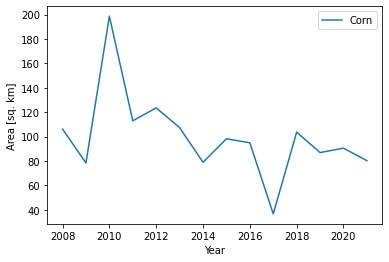

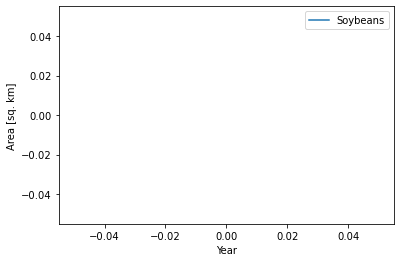

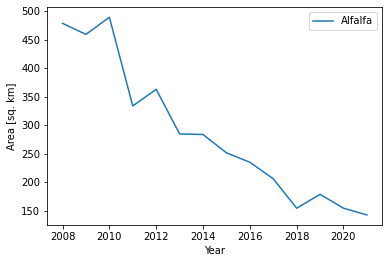

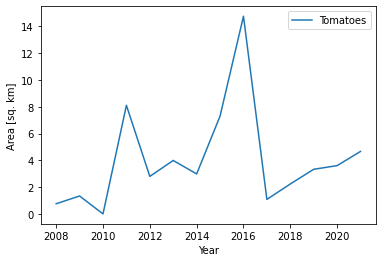

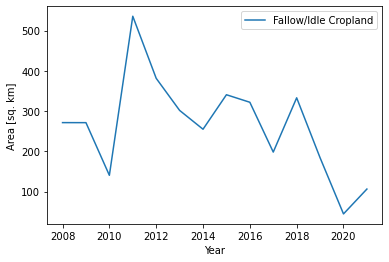

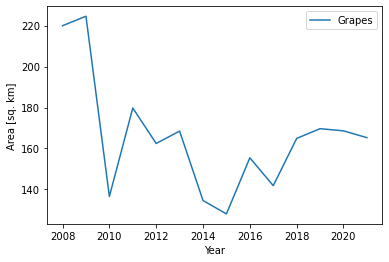

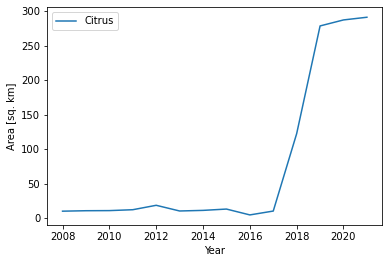

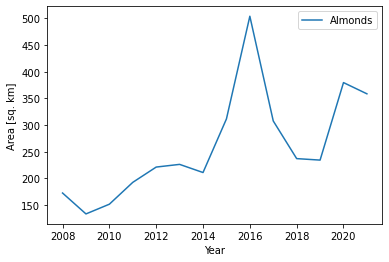

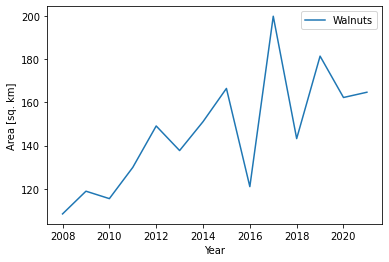

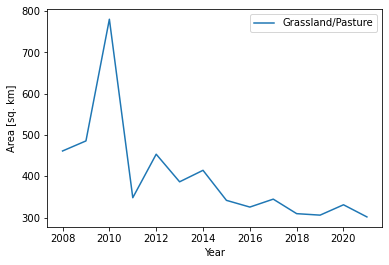

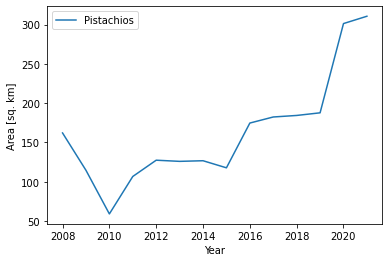

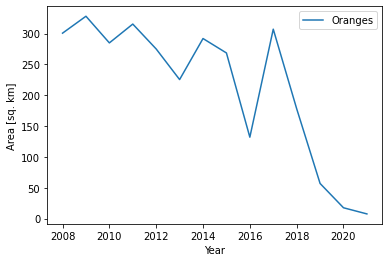

In [250]:
yr_ser = range(2008,2022)
crop_sel = [0,4,35,53,60,68,71,74,75,175,203,211,]
for i in crop_sel:
    val = crop_df.iloc[i,3:]
    c_type = crop_df.iloc[i,1]
    df_pl = pd.DataFrame({'Year': yr_ser, 'Area_sqkm' :list(val)})
    df_pl.head(3)

    df_pl.plot(x = 'Year', y = 'Area_sqkm', label = c_type,ylabel = 'Area [sq. km]')